<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Data and Kaggle Challenge
### Notebook #3 for Kaggle Submission

**Import Libraries Required**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

**Import Cleaned Datasets**

In [2]:
#import datasets
df_train = pd.read_csv('../data/train-clean.csv')
df_test = pd.read_csv('../data/test-clean.csv')

**Data Preprocessing**

*`pri_sch_name` and `sec_sch_name`*

Convert pri_sch_name and sec_sch_name to numerical value by classifying them as:

* Top school = 1
* Other School = 0

Top school definition is based on the following source:

* [`2022 Primary School Ranking`](https://schoolbell.sg/primary-school-ranking/)
* [`2022 Secondary School Ranking`](https://schoolbell.sg/secondary-school-ranking/)

In [3]:
#create top school list for primary school and secondary school
top_pri_sch = ['Rosyth School','Nan Hua Primary School',"Saint Hilda's Primary School",
               'Catholic High School','Henry Park Primary School','Nanyang Primary School',
               'Tao Nan School',"Raffles Girls' School"]

top_sec_sch = ["Raffles Girls' School", 'Raffles Institution',"CHIJ Saint Nicholas Girls' School",
               'Anglo-Chinese School',"Methodist Girls' School",'Dunman High School','Catholic High School',
               "Cedar Girls' Secondary School",'Temasek Junior College','River Valley High School']

#convert school name to numerical value based on top school or not
#convert train datasets 
df_train['pri_sch_name'] = df_train['pri_sch_name'].apply(lambda x: 1 if x in top_pri_sch else 0)
df_train['sec_sch_name'] = df_train['sec_sch_name'].apply(lambda x: 1 if x in top_sec_sch else 0)
# #convert test datasets
df_test['pri_sch_name'] = df_test['pri_sch_name'].apply(lambda x: 1 if x in top_pri_sch else 0)
df_test['sec_sch_name'] = df_test['sec_sch_name'].apply(lambda x: 1 if x in top_sec_sch else 0)


`region`

Create new column to distibute `planning_area` as:

* Central Region(cr) = 1
* Outside Central Region(ocr) = 0

Source: [`Definition of CCR, RCR and OCR`](https://www.propertyguru.com.sg/property-guides/ccr-ocr-rcr-region-singapore-ura-map-21045). This article explains the distribution of each `planning_area` based on the region

Note: From the source there are distrubition of 3 areas which area CCR(Central), RCR (Rest of Central Region) and OCR. For this project, CCR and RCR are combined as one defined as `Central Region` 



In [4]:
#create list of central region 
cr = ['Bukit Timah','Downtown Core','Novena','Tanglin','Bishan',
      'Geylang','Kallang','Marine Parade','Outram','Queenstown',
      'Rochor','Toa Payoh', 'Bukit Merah']

#create list of outside central region
ocr = ['Ang Mo Kio', 'Bedok','Bukit Batok','Bukit Panjang', 'Changi', 'Choa Chu Kang',
       'Clementi','Hougang','Jurong East','Jurong West','Pasir Ris','Punggol','Sembawang',
       'Sengkang','Serangoon','Tampines','Western Water Catchment','Woodlands','Yishun']

#create empty list of region
region_train = []
for place in df_train['planning_area']:
    if place in cr:
        region_train.append(1)
    else:
        region_train.append(0)

#convert from list to dataframe
region_train = pd.DataFrame(region_train, columns = ['region'])

#combine to train datasets 
df_train = pd.concat([df_train,region_train], axis=1)

#create region dataset for test model
region_test = []
for place in df_test['planning_area']:
    if place in cr:
        region_test.append(1)
    else:
        region_test.append(0)

#convert from list to dataframe
region_test = pd.DataFrame(region_test, columns = ['region'])

#combine to test datasets 
df_test = pd.concat([df_test,region_test], axis=1)

`town`

Because there is a column named as `planning area`, and it can represent `town`, convert `town` from categorical to numerical value by:

* Mature Estate = 1
* Non-Mature Estate = 0 

Source: [`Non-Mature and Mature Estates`](https://www.propertyguru.com.sg/property-guides/non-mature-vs-mature-bto-55760). This article explains the distribution of `town` based on mature and non-mature estate


In [5]:
#create mature estate list 
mature_estate_list = ['ANG MO KIO','BEDOK','BISHAN','BUKIT MERAH',
                      'BUKIT TIMAH','CENTRAL AREA','CLEMENTI',
                      'GEYLANG','KALLANG/WHAMPOA','MARINE PARADE',
                      'PASIR RIS','QUEENSTOWN','SERANGOON',
                      'TAMPINES','TOA PAYOH']

#train model
df_train['town'] = df_train['town'].apply(lambda x: 1 if x in mature_estate_list else 0)

#test model
df_test['town'] = df_test['town'].apply(lambda x: 1 if x in mature_estate_list else 0)


### Model Creation

In [6]:
#features list for modelling (numerical value)
features = ['town','floor_area_sqft','hdb_age','max_floor_lvl','mid_storey',
            '1room_sold','2room_sold','3room_sold','4room_sold','5room_sold',
            'exec_sold','multigen_sold','studio_apartment_sold','cutoff_point',
            'affiliation','sec_sch_name','pri_sch_name','mrt_nearest_distance',
            'pri_sch_nearest_distance','sec_sch_nearest_dist','hawker_within_2km'
            ,'region']

**Dummify variables**

In [7]:
#dummify planning area
planning_area_dummy = pd.get_dummies(df_train['planning_area'], drop_first=True, dtype= int)

#dummify flat model
flat_model_dummy = pd.get_dummies(df_train['flat_type'], drop_first = True, dtype = int)

#dummify flat model
flat_type_dummy = pd.get_dummies(df_train['flat_model'], drop_first = True, dtype = int)

**Model Prep: Define X and Y variables for regression model**

In [8]:
#define datasets for modelling
x_df = pd.concat([df_train[features],planning_area_dummy,flat_model_dummy,flat_type_dummy], axis = 1)

#define X and Y
X = x_df
y = df_train['resale_price']

**Model Prep: Create train and test split model**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

**Model Prep: Scale X variable**

Because there are significant value differences between some features, for example `floor_area_sqft` and `hdb_age` 

In [10]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

**Create Model: Ridge Regression**

In [11]:
#instantiate Ridge model
ridge = RidgeCV(np.linspace(1,5,100))

In [12]:
#fit to ridge model 
ridge.fit(X_train_ss,y_train)

RidgeCV(alphas=array([1.        , 1.04040404, 1.08080808, 1.12121212, 1.16161616,
       1.2020202 , 1.24242424, 1.28282828, 1.32323232, 1.36363636,
       1.4040404 , 1.44444444, 1.48484848, 1.52525253, 1.56565657,
       1.60606061, 1.64646465, 1.68686869, 1.72727273, 1.76767677,
       1.80808081, 1.84848485, 1.88888889, 1.92929293, 1.96969697,
       2.01010101, 2.05050505, 2.09090909, 2.13131313, 2.17171717,
       2.212121...
       3.62626263, 3.66666667, 3.70707071, 3.74747475, 3.78787879,
       3.82828283, 3.86868687, 3.90909091, 3.94949495, 3.98989899,
       4.03030303, 4.07070707, 4.11111111, 4.15151515, 4.19191919,
       4.23232323, 4.27272727, 4.31313131, 4.35353535, 4.39393939,
       4.43434343, 4.47474747, 4.51515152, 4.55555556, 4.5959596 ,
       4.63636364, 4.67676768, 4.71717172, 4.75757576, 4.7979798 ,
       4.83838384, 4.87878788, 4.91919192, 4.95959596, 5.        ]))

In [13]:
print(f'Ridge Regression cross_val_score on train : {cross_val_score(ridge, X_train_ss, y_train, cv=5).mean()}')
print(f'Ridge Regression cross_val_score on test: {cross_val_score(ridge, X_test_ss, y_test, cv=5).mean()}')

Ridge Regression cross_val_score on train : 0.8733312670212877
Ridge Regression cross_val_score on test: 0.8720581866386908


*Cross validated scores are similar for both test and train models, this model fits well*

In [14]:
#create prediction variable 
ridge_preds = ridge.predict(X_train_ss)

In [15]:
print(f"The model r_square value is: {metrics.r2_score(y_train,ridge_preds)}")
print(f"The model mean absolute percentage error is: {metrics.mean_absolute_percentage_error(y_train,ridge_preds)}")
print(f"The model mean squared error is: {metrics.mean_squared_error(y_train,ridge_preds)}")

The model r_square value is: 0.8735628553184296
The model mean absolute percentage error is: 0.09404605631221673
The model mean squared error is: 2589471756.943311


        Column_Name  Coefficient_Value
0              town       66413.023122
1   floor_area_sqft       80420.922635
2           hdb_age      -40825.223629
3     max_floor_lvl       23629.488683
4        mid_storey       18623.958004
..              ...                ...
73       Simplified        -608.817840
74         Standard       -1123.447234
75          Terrace       10065.578864
76          Type S1        3281.985151
77          Type S2        4043.093913

[78 rows x 2 columns]


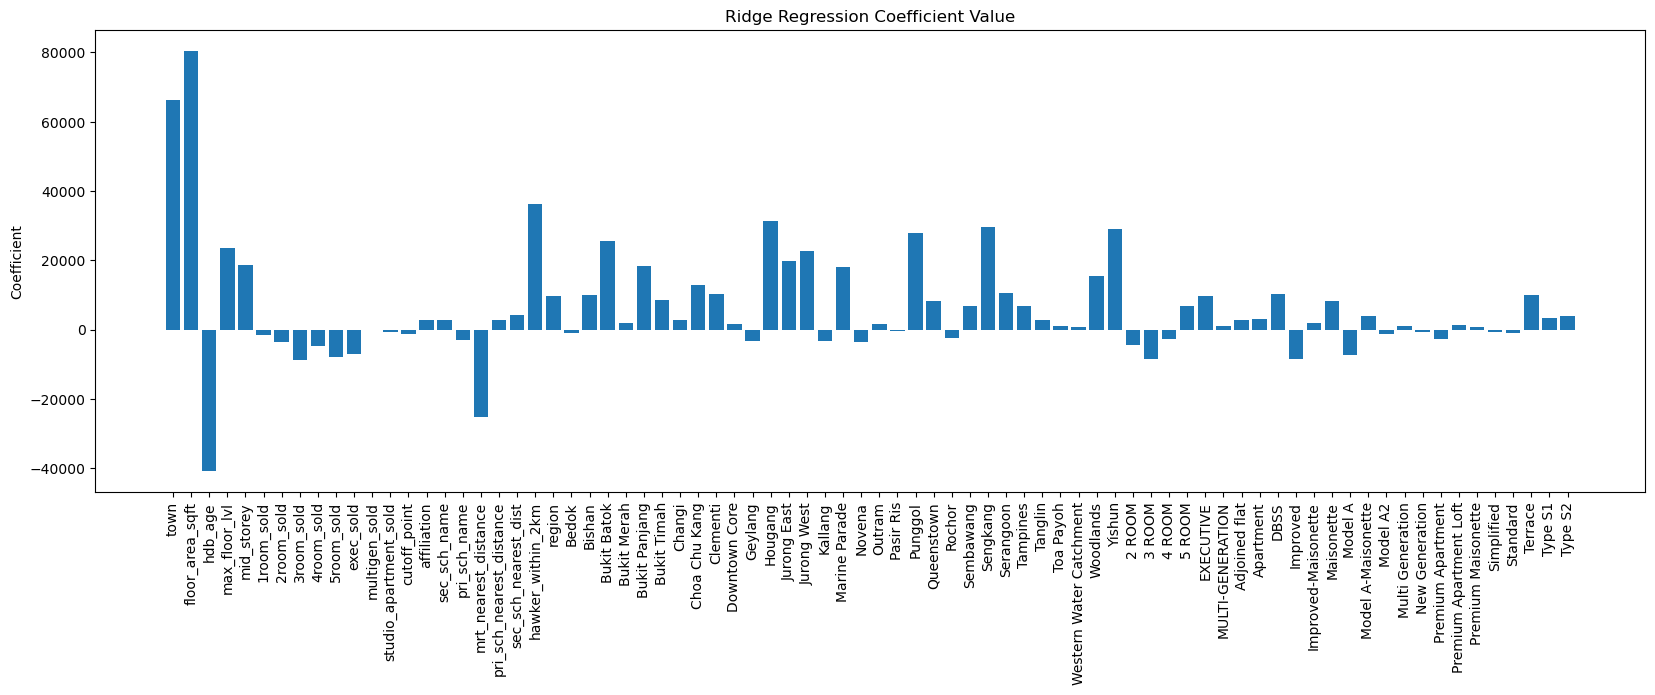

In [16]:
# Create df for storing coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

# Storing all the column names of predictors
coefficient_df['Column_Name'] = X_train.columns

# Store coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(ridge.coef_)

# Preview variables' coefficient values
# The higher the values, the stronger the variables
print(coefficient_df)

# Plot the coefficent values
# Goal is to tune the model so that we get a more stable model i.e. similar size coefficient values
plt.rcParams['figure.figsize'] = (20,6);
plt.bar(coefficient_df["Column_Name"], coefficient_df['Coefficient_Value']);
plt.xticks(rotation= 90);
plt.ylabel('Coefficient');
plt.title('Ridge Regression Coefficient Value');

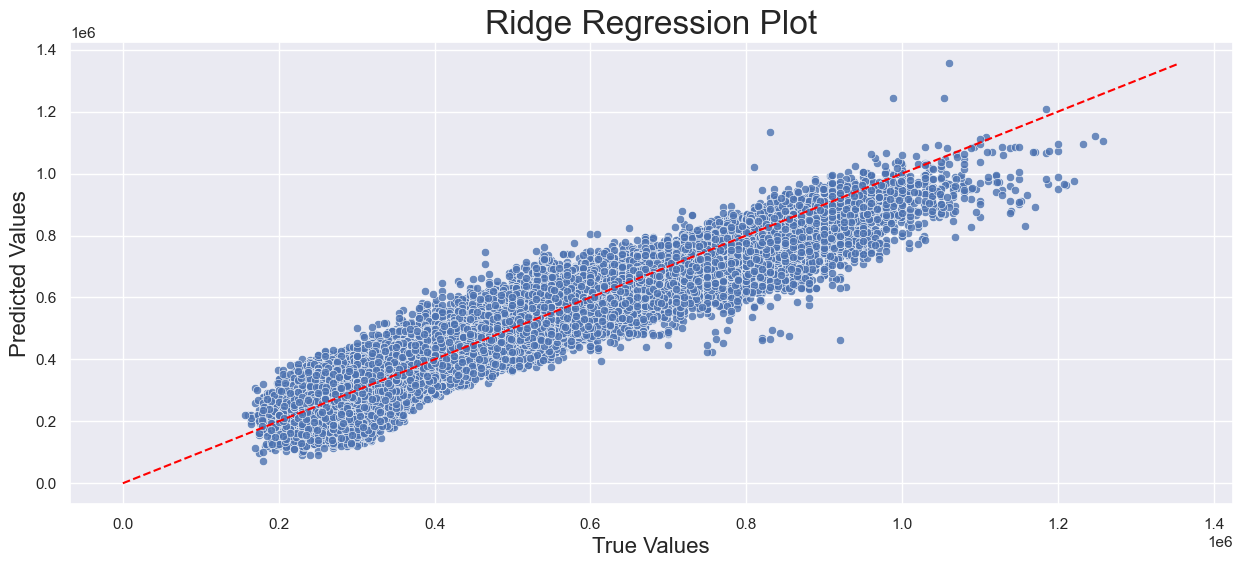

In [17]:
#plot ridge model 
plt.figure(figsize= (15,6))
sns.set_theme()
sns.scatterplot(x = y_train, y = ridge_preds, alpha = 0.8)
plt.ylabel("Actual Resale Price")
plt.xlabel("Predicted Resale Price")
plt.title("Ridge Regression Model");

#create perfect regression line reference
#create perfect regression line reference
plt.plot([0, max(max(y_test),max(ridge_preds))],
         [0, max(max(y_test),max(ridge_preds))],
         linestyle = '--', color = 'red')

plt.title('Ridge Regression Plot', fontsize = 24)
plt.xlabel('True Values', fontsize = 16)
plt.ylabel('Predicted Values', fontsize = 16);

|Model|cross_val_score(train)|cross_val_score(test)|
|---|---|---|
|Linear Regression|0.873|-7.352e+23|
|Ridge Regression|0.873|0.872|
|Lasso Regression|0.872|0.871|

*Comparing the three model, ridge has higher cross_val_score and the model fits. Therefore, `Rigde` model is used to predict the test datasets resale price.*
<br>
- *Coefficient of determination, $R^2$ score: $0.87$*
- *Mean absolute percentage error, MAPE score: $9.4\%$*

### **Kaggle Submission**

In [18]:
df_test.head()

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude,region
0,114982,2012-11,0,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,0,1.433681,103.832924,156.322353,0,218,0,1.436235,103.829987,0
1,95653,2019-08,0,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,0,1.339244,103.698896,739.371688,0,199,0,1.335256,103.702098,0
2,40303,2013-10,1,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,0,1.371893,103.851811,305.071191,0,245,0,1.374242,103.851430,0
3,109506,2017-10,0,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,...,0,1.434423,103.773698,433.454591,0,188,0,1.439183,103.774499,0
4,100149,2016-08,0,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,...,0,1.349195,103.741000,217.295361,0,223,0,1.348351,103.740873,0


**Dummify test variables**

In [19]:
test_planning_area_dummy = pd.get_dummies(df_test['planning_area'], drop_first=True, dtype= int)

#dummify flat model
test_flat_model_dummy = pd.get_dummies(df_test['flat_type'], drop_first = True, dtype = int)

#dummify flat model
test_flat_type_dummy = pd.get_dummies(df_test['flat_model'], drop_first = True, dtype = int)

In [20]:
x_test_df = pd.concat([df_test[features],test_planning_area_dummy,test_flat_type_dummy,test_flat_model_dummy],axis =1)

**Check number of columns between Kaggle train and test models**

In [21]:
X.shape

(150634, 78)

In [22]:
x_test_df.shape

(16737, 77)

*One column is missing on test model*

**Add missing column to Kaggle test datasets and rearrange**

In [23]:
#identify missing columns:
missing = []
for name in X.columns:
    if name not in x_test_df:
        missing.append(name)

In [24]:
#add to test dataframe 

x_test_df[missing] = 0

In [25]:
#re-arrange test column based on train test column
x_test_df = x_test_df[X.columns]

**Scaling of test features**

In [26]:
kaggle_X_test = x_test_df

kaggle_X_test_ss = ss.transform(kaggle_X_test)

**Fit Ridge model to test dataset**

In [27]:
kaggle_y_pred = ridge.predict(kaggle_X_test_ss)

**Create and export csv file for Kaggle submission**

In [28]:
#create dataframe for kaggle_y_pred
df_kaggle_y_pred = pd.DataFrame(kaggle_y_pred, columns=['Predicted'] )

In [29]:
#create csv file for kaggle submssion
df_kaggle_csv = pd.concat([df_test['id'],df_kaggle_y_pred],axis=1)

In [30]:
#rename Id based on kaggle requirement
df_kaggle_csv = df_kaggle_csv.rename(columns={'id':'Id'})

In [31]:
df_kaggle_csv

,Id,Predicted
0,114982,337320.581814
1,95653,522952.255395
2,40303,344527.322309
3,109506,286540.001899
4,100149,457762.166832
...,...,...
16732,23347,352622.959230
16733,54003,513245.385247
16734,128921,417384.290961
16735,69352,490349.160791


In [32]:
# df_kaggle_csv.to_csv('../kaggle/kaggle-sub.csv', index = False)

**Screenshot of Kaggle submission**

![Kaggle Submission](../kaggle/group-kaggle-submission.png)